In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools
from tools import cmp

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
# read in the crowley data
adata = sc.read_h5ad('dataset/Chen/chen_11_filtered_lymphoid.h5ad')
adata = adata.raw.to_adata()
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 18269 × 39899
    obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'leiden', 'leiden_R', 'celltypes'
    var: 'GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypes_colors', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

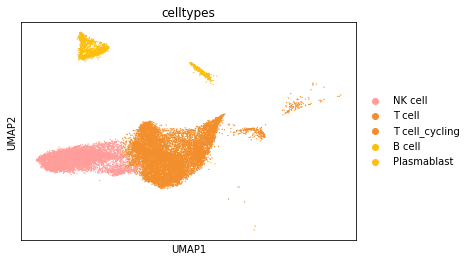

In [3]:
sc.pl.umap(adata, color = 'celltypes')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


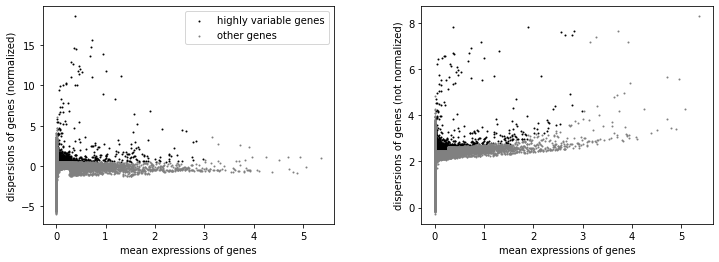

In [4]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [5]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:28)


In [6]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


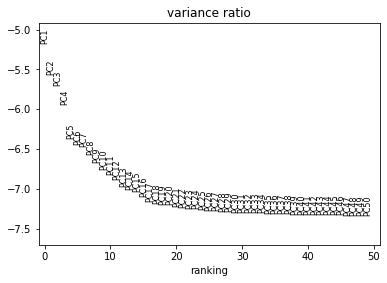

In [7]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [8]:
import bbknn
bbknn.bbknn(adata, batch_key='sample')
# sc.pp.neighbors(adata)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [9]:
sc.tl.umap(adata, min_dist = 0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


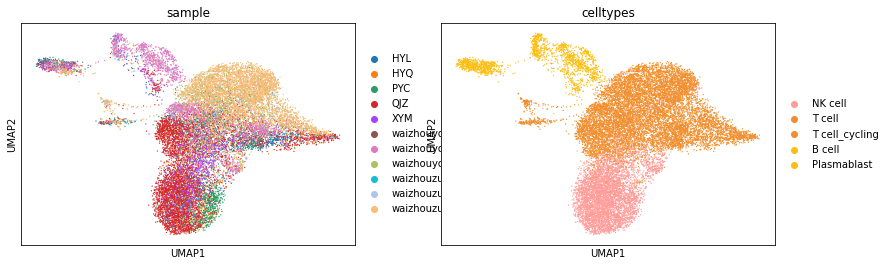

In [10]:
sc.pl.umap(adata, color = ['sample', 'celltypes'])

In [11]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


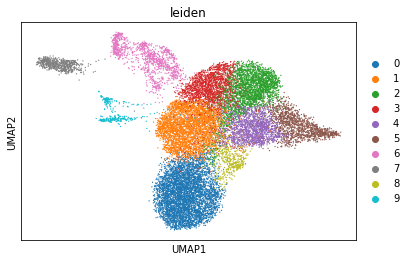

In [12]:
sc.pl.umap(adata, color = 'leiden')

In [15]:
# sc.tl.leiden(adata, restrict_to = ('leiden', ['4']), resolution = .5)

In [14]:
# sc.pl.umap(adata, color = 'leiden_R')

In [13]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:36)


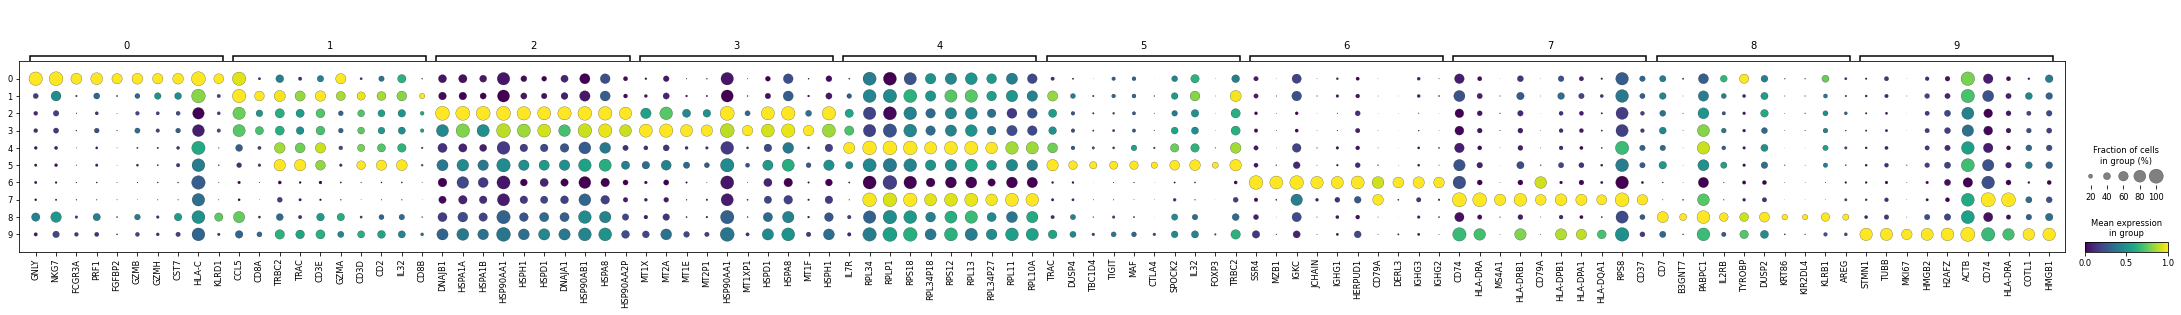

In [14]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 10, min_logfoldchange = 1, standard_scale = 'var', color_map = 'viridis', dendrogram = False)

In [15]:
from tools import cmp

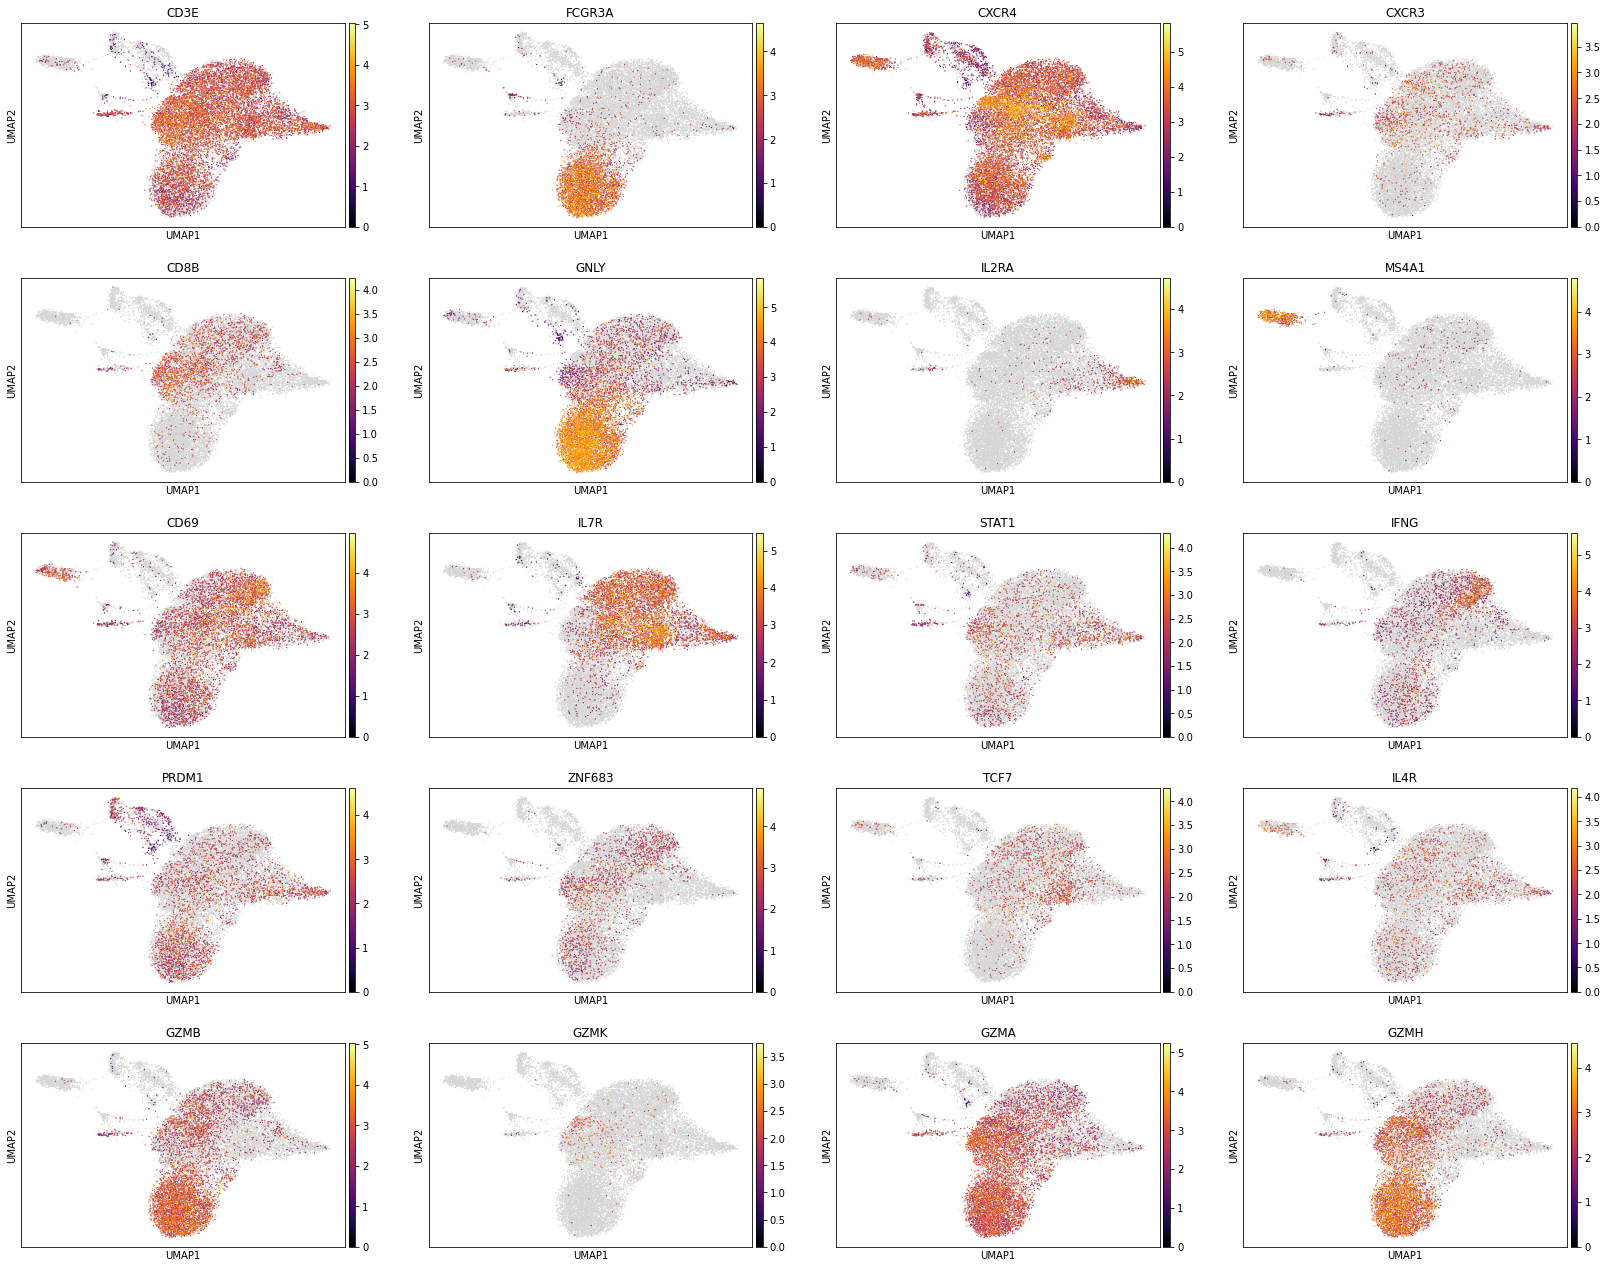

In [16]:
sc.pl.umap(adata, color = ['CD3E', 'FCGR3A', 'CXCR4', 'CXCR3', 'CD8B', 'GNLY', 'IL2RA', 'MS4A1', 'CD69', 'IL7R', 'STAT1', 'IFNG', 'PRDM1', 'ZNF683', 'TCF7', 'IL4R', 'GZMB', 'GZMK', 'GZMA', 'GZMH'], color_map = cmp('inferno'))

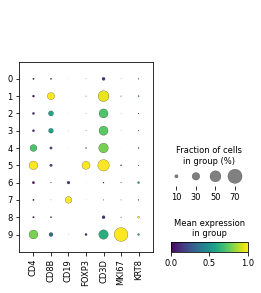

In [17]:
sc.pl.dotplot(adata, ['CD4', 'CD8B', 'CD19', 'FOXP3', 'CD3D', 'MKI67', 'KRT8'], groupby = 'leiden', standard_scale = 'var', color_map = 'viridis')

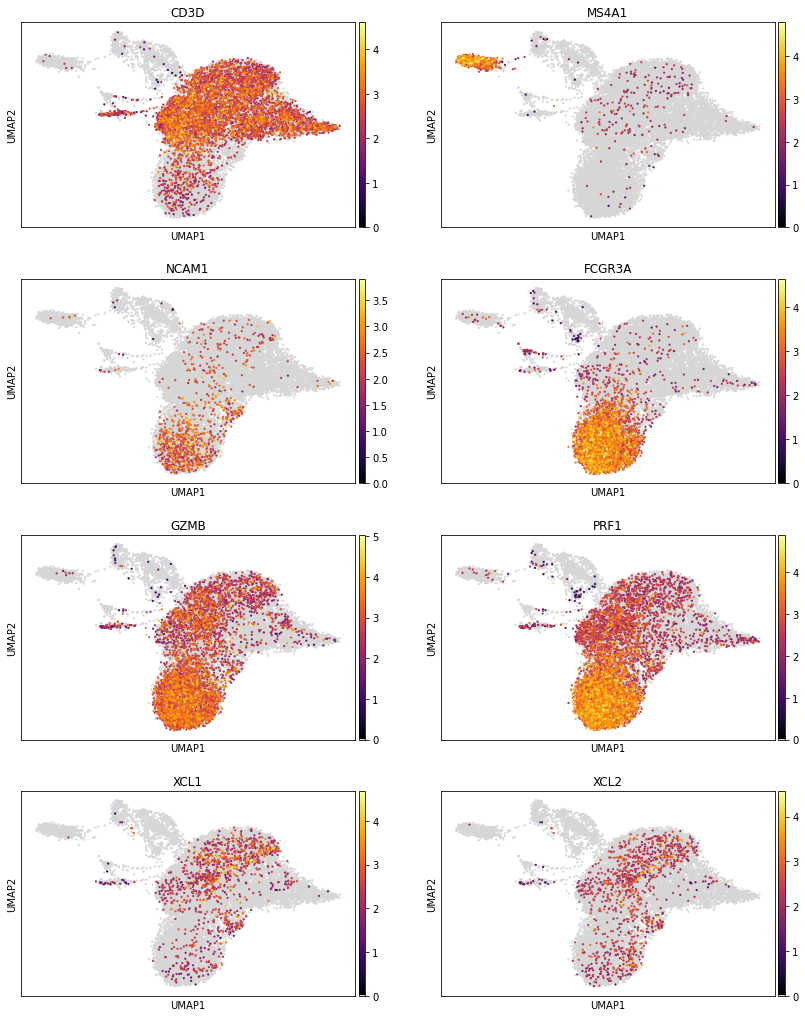

In [18]:
sc.pl.umap(adata, color = ['CD3D', 'MS4A1', 'NCAM1', 'FCGR3A', 'GZMB', 'PRF1', 'XCL1', 'XCL2'], color_map = cmp('inferno'), ncols = 2, size = 20)

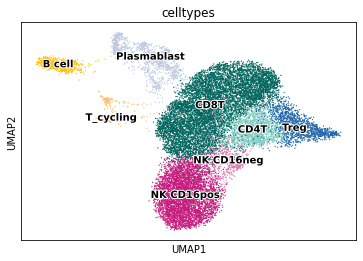

In [19]:
celltypes={
    '0':'NK CD16pos',
    '1':'CD8T',
    '2':'CD8T',
    '3':'CD8T',
    '4':'CD4T',
    '5':'Treg',
    '6':'Plasmablast',
    '7':'B cell',
    '8':'NK CD16neg',
    '9':'T_cycling',
}
cols = {
    'CD8T':'#01665e',
    'T_cycling':'#fdbf6f',
    'CD4T':'#80cdc1',
    'NKT':'#d7b5d8',
    'NK CD16pos':'#c51b7d',
    'NK CD16neg':'#de77ae',
    'Treg':'#2166ac',
    'B cell':'#fcbf10',
    'Plasmablast':'#bdc9e1',
}
adata.obs['celltypes'] = [celltypes[l] for l in adata.obs['leiden']]
adata.obs['celltypes'] = adata.obs['celltypes'].astype('category')
adata.obs['celltypes'] = adata.obs['celltypes'].cat.reorder_categories([k for k in cols.keys() if k in list(adata.obs['celltypes'])])
sc.pl.umap(adata, color = 'celltypes', palette = cols, legend_loc = 'on data', legend_fontoutline = 2)

In [20]:
adata.write_h5ad('dataset/Chen/chen_11_filtered_lymphoid_annotated.h5ad', compression = 'gzip')